# 简易房价预测+解释系统
- **数据来源: 贝壳找房，武汉新房信息**
- **解释方法: [SHAP值](https://github.com/slundberg/shap)**
- **基于区位+面积+户型，采用树模型预测房价** 
- 主要看一哈SHAP解释好不好用

In [1]:
import xgboost
import shap
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

In [2]:
# read in the data
file = './data/new/wh.csv'
df = pd.read_csv(file,parse_dates=True)
df['日期'] = pd.to_datetime(df['日期'],format="%Y%m%d")
df.head()

,日期,楼盘,单价,底价,地区,户型,面积
0,2020-10-02,首开&华侨城&金茂|东湖金茂府,26500,300万,洪山/青山,3/4,118-141
1,2020-10-02,长江凯旋城,11300,122万,黄陂/武湖,3,108-124
2,2020-10-02,美好长江首玺,13500,125万,洪山/白沙洲,3,97-123
3,2020-10-02,海伦堡汉江府,8200,79万,东西湖/东西湖其它,3/4,96-130
4,2020-10-02,兰亭大境,16250,171万,沌口开发区/沌口,3/4,105-143


In [3]:
# prepare the data

df['单价'] = df['单价'].replace('价格待定',None).astype(float)
df.dropna(inplace=True)

df['底价'] = df['底价'].str.strip('万')
df['底价'] = df['底价'].astype(float)

# 将地区转为具体行政区和商圈
df['行政区'] = [i.split('/')[0] for i in df['地区']]
df['商圈'] = [i.split('/')[1] for i in df['地区']]

#将面积转为最大面积和最小面积
area = [i.split('-') for i in df['面积']]
df['最小面积'] = [i[0] for i in area]
df['最大面积'] = [i[1] if len(i)==2 else i[0] for i in area ]
df['最小面积'] = df['最小面积'].astype(int)
df['最大面积'] = df['最大面积'].astype(int)
# df['最小户型'] = df['户型'].str.split('/')[0]
# df['最大户型'] = df['户型'].str.split('/')[-1]
df['最小户型'] = [0]*len(df)
df['最大户型'] = [0]*len(df)
for i in range(len(df)):
    tmp = df['户型'][i].split('/')
    try:
        df['最小户型'][i] = tmp[0]
        df['最大户型'][i] = tmp[-1]
    except:
        df['最小户型'][i] = None
        df['最大户型'][i] = None
        
df['最小户型'] = df['最小户型'].astype(int)
df['最大户型'] = df['最大户型'].astype(int)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [40]:
df_a = df[df['最小面积']>0]
df_a = df_a[df_a['最小户型']>0]
df_a = df_a[df_a['单价']>3000]
df_a = df_a.drop(['日期','底价','地区','户型','面积','商圈',],axis=1)
print(df_a.shape)
df_a.to_csv('./data/wh_clean.csv')
df_a.head()

(627, 7)


,楼盘,单价,行政区,最小面积,最大面积,最小户型,最大户型
0,首开&华侨城&金茂|东湖金茂府,26500.0,洪山,118,141,3,4
1,长江凯旋城,11300.0,黄陂,108,124,3,3
2,美好长江首玺,13500.0,洪山,97,123,3,3
3,海伦堡汉江府,8200.0,东西湖,96,130,3,4
4,兰亭大境,16250.0,沌口开发区,105,143,3,4


In [5]:
# 将行政区映射到categorical的数据
def xzq_to_val(x):
    if x=='东湖高新':
        return 1
    if x=='黄陂':
        return 2
    if x=='东西湖':
        return 3
    if x=='汉阳':
        return 4
    if x=='洪山':
        return 5
    if x=='新洲':
        return 6
    if x=='江岸':
        return 7
    if x=='江夏':
        return 8
    if x=='蔡甸':
        return 9
    if x=='沌口开发区':
        return 10
    if x=='硚口':
        return 11
    if x=='江汉':
        return 12
    if x=='武昌':
        return 13
    if x=='汉南':
        return 14
    if x=='青山':
        return 15
    if x=='鄂城区':
        return 16
    if x=='葛店开发区':
        return 17

In [6]:
# Create XGBoost data objects
X = df_a.drop(['楼盘','单价'],axis=1)
X['行政区'] = X['行政区'].apply(lambda x:xzq_to_val(x))
y = df_a['单价']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

xgb_full = xgboost.DMatrix(X, label=y)
xgb_train = xgboost.DMatrix(X_train, label=y_train)
xgb_test = xgboost.DMatrix(X_test, label=y_test)

In [7]:
params = {
    "eta": 0.002,
    "max_depth": 3,
    "objective": "reg:linear",
    "subsample": 0.5
}
model_train = xgboost.train(params, xgb_train, 10000, evals = [(xgb_test, "test")], verbose_eval=1000)
y_pred = model_train.predict(xgb_test)
print('RMSE: {}'.format(mean_squared_error(y_test,y_pred)))

[22:43:01] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[0]	test-rmse:18295.89062
[1000]	test-rmse:7145.40430
[2000]	test-rmse:7172.69434
[3000]	test-rmse:7264.09668
[4000]	test-rmse:7308.52246
[5000]	test-rmse:7343.34863
[6000]	test-rmse:7407.89355
[7000]	test-rmse:7472.15478
[8000]	test-rmse:7513.32812
[9000]	test-rmse:7560.51807
[9999]	test-rmse:7613.97070
[22:43:04] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
Validation: 57972549.16320203


#### 散点图展示XGBoost的预测结果
看起来还挺准的

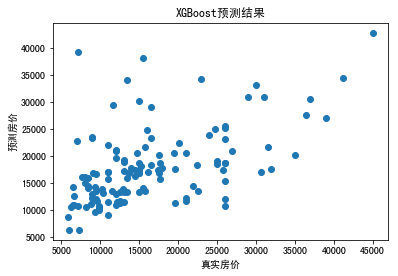

In [8]:
import matplotlib.pyplot as plt
plt.scatter(y_test,y_pred)
plt.xlabel('真实房价')
plt.ylabel('预测房价')
plt.title('XGBoost预测结果')
plt.show()

In [9]:
shap_values = shap.TreeExplainer(model_train).shap_values(X)

## SHAP Summary Plot

- SHAP值解释了每一个特征是如何独立影响最终模型的，即特征的改变是如何影响房价的最终预测值。就本图来看，影响房价最重要的因素是行政区位，其次是面积，最后是户型。
- 采用SHAP值，而不是传统的柱状图，作为特征重要性展示，可以告诉我们更多的信息: ① 哪个特征最为重要; ② 特征对于模型是正向还是负向的影响。
- 如本例中，可以看出最大/最小面积越大，房屋价格倾向越高，即对房价是正反馈。

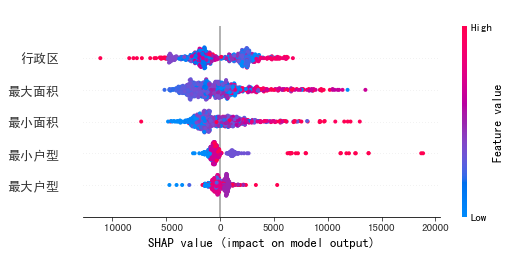

In [10]:
shap.summary_plot(shap_values, X)

### SHAP Dependence Plots
- SHAP summary plot给出了哪个特征更重要。而SHAP dependence plot则表示了模型在某一具体特征改变时，输出是如何变化的。每个点代表一个房源。散点在垂直方向上的色散表示与其他特征的交互作用。
- 横轴为该特征的取值，纵轴为该特征的沙普利值。
- 如本图表示了行政区与最大面积之间的交互作用，在一些行政区，最小面积越大可能是有利于房价的正向预测，即房屋单价更高，如7(江岸)，8(江夏)，而一些地区则可能是负相关，如12(江汉)，14(汉南)。
- 某些行政区对于房屋单价是正向影响的，如12(江汉)，13(武昌)，某些则是负向的，如6(新洲)，14(汉南)

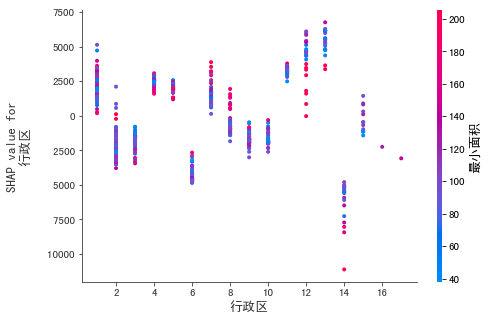

In [29]:
shap.dependence_plot('行政区', shap_values, X, interaction_index='最小面积')

### Compute SHAP Interaction Values
- SHAP interaction value是为了展示特征之间的交互情况。
- *See the Tree SHAP paper for more details, but briefly, SHAP interaction values are a generalization of SHAP values to higher order interactions. Fast exact computation of pairwise interactions are implemented in the latest version of XGBoost with the pred_interactions flag. With this flag XGBoost returns a matrix for every prediction, where the main effects are on the diagonal and the interaction effects are off-diagonal. The main effects are similar to the SHAP values you would get for a linear model, and the interaction effects captures all the higher-order interactions are divide them up among the pairwise interaction terms. Note that the sum of the entire interaction matrix is the difference between the model's current output and expected output, and so the interaction effects on the off-diagonal are split in half (since there are two of each). When plotting interaction effects the SHAP package automatically multiplies the off-diagonal values by two to get the full interaction effect.*

In [14]:
# takes a couple minutes since SHAP interaction values take a factor of 2 * # features
# more time than SHAP values to compute, since this is just an example we only explain
shap_interaction_values = shap.TreeExplainer(model_train).shap_interaction_values(X)

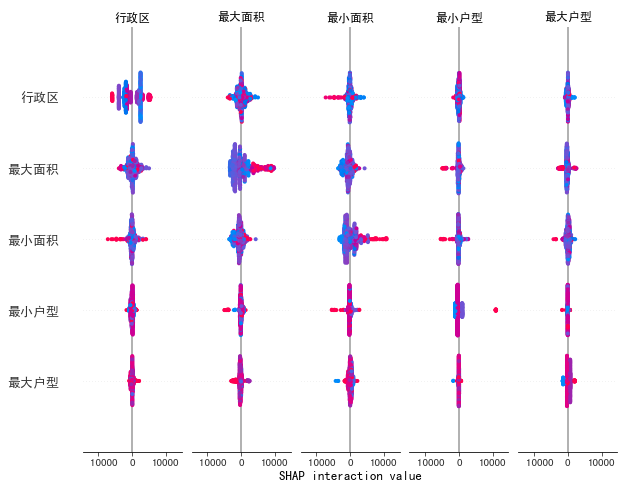

In [15]:
shap.summary_plot(shap_interaction_values, X)

### SHAP Interaction Value Dependence Plots
- SHAP dependence plot 展示了某一特征是如何交互影响最终沙普利值的。
- Running a dependence plot on the SHAP interaction values allows us to separately observe the main effects and the interaction effects.
- 本图为最小面积的交互沙普利值图，当最小面积在小于300㎡时，沙普利值随着最小面积增大有显著增加的倾向，即最小面积对于决定最后预测价格有更大的作用，当面积大于300㎡时，沙普利值骤降，即最小面积对房屋单价的影响显著下降。

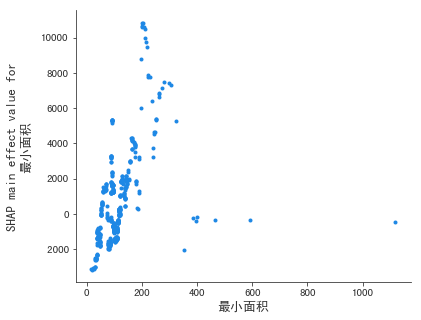

In [24]:
shap.dependence_plot(
    ("最小面积", "最小面积"),
    shap_interaction_values, X
)

- 本图为行政区交互沙普利图，可以看到，对于12(江汉)，13(武昌)，其对于房价有很高的正向影响，6(新洲)，14(汉南)则对房价有较高的负向影响，一定程度上反映了行政区位对于房价的影响力。

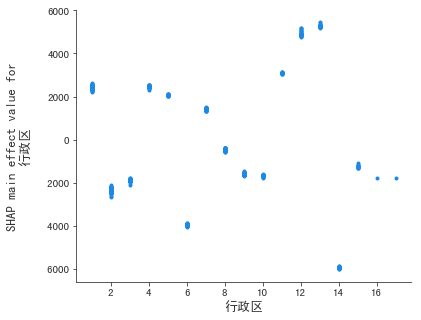

In [25]:
shap.dependence_plot(
    ("行政区", "行政区"),
    shap_interaction_values, X)

#### 以上为对数据集的整体分析，下面选取一些数据点，做单独分析。
- **即from global interpretation to local interpretation**

In [32]:
shap.initjs()

In [45]:
# 纽宾凯麓院
shap.force_plot(explainer.expected_value, shap_values[179,:], X.iloc[179,:])

![纽宾凯麓院](./output/shap1.png)

- 上图为纽宾凯麓院的预测结果
- 预测单价为18307
- 行政区位于东湖高新，最大面积为186对预测产生了正向的影响；最小面积为96，最小户型为3，最大户型为4对模型预测产生了负向的影响。

In [46]:
# 光谷未来城
shap.force_plot(explainer.expected_value, shap_values[205,:], X.iloc[205,:])

![光谷未来城](./output/shap2.png)

- 上图为光谷未来城的预测结果
- 预测单价为23600
- 行政区位于东湖高新，最大面积为159，最小面积为126，最大户型为3对预测产生了正向的影响；，最小户型为3对模型预测产生了负向的影响。

- **如果我们把所有的数据点的解释堆叠在一起，并旋转90度，就可以得到对整个数据集的解释(图像基于js，notebook中可交互)**
- ***If we take many explanations such as the one shown above, rotate them 90 degrees, and then stack them horizontally, we can see explanations for an entire dataset (in the notebook this plot is interactive):***

In [35]:
explainer = shap.TreeExplainer(model_train)
shap.force_plot(explainer.expected_value, shap_values, X)

![shap3](./output/shap3.png)
![shap4](./output/shap4.png)
![shap5](./output/shap5.png)
![shap6](./output/shap6.png)

- **以上就是采用SHAP解释机器学习模型的主要方式。**
- 功能十分强大，可以发现一些藏在数据背后的关系，即特征对于最后预测结果的作用并非是简单加和。
- 解释具有可比较性、选择性，对缺失值容忍度高。
- 解释符合先验经验，如某些行政区房价更有竞争力，小户型(2-3)、中等面积(100㎡-300㎡)的房屋更吃香。